<a href="https://colab.research.google.com/github/jesst0x/image-segmentation-in-dark/blob/main/Diffusion_Model_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'AI/diffusion_model'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  24916      0 --:--:-- --:--:-- --:--:-- 24850
OK
51 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 51 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121918 files and directories cur

In [3]:
### Connect to gs bucket
from google.colab import auth
auth.authenticate_user()

In [4]:
# Loading data from gs bucket
!mkdir coco
!gcsfuse cs231n_lls coco
!gcsfuse --implicit-dirs cs231n_lls coco

{"timestamp":{"seconds":1717223140,"nanos":830480909},"severity":"INFO","message":"Start gcsfuse/2.2.0 (Go version go1.22.3) for app \"\" using mount point: /content/coco\n"}
{"timestamp":{"seconds":1717223140,"nanos":830755909},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":false,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":false,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier\":2,\"LocalFileCache\":false,\"TempDir\"

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
!pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [7]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import kornia
import json
import os
import torchvision
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

## Custom Dataset

As we need to have a pair of input images,ie. natural image and darkened synthetic image (conditional image) for diffusion model, we will build a custom dataset to load the data.

In [8]:
class ConditionalDiffusionDataset(Dataset):
  """
  Dataset for conditional diffusion model.
  Args:
    natural_img_dir (string): Root directory of dataset as input to be noised in diffusion model.
    conditinal_img_dir (string): Root directory of images used as condition in diffusion model.
    anno_path (string): Path to the annotation json file, consisting of image file name.
    transform (callable, optional): Optional transform to be applied
      on input_image

  """
  def __init__(self, input_img_dir, conditional_img_dir, anno_path, transform=None):
    self.natural_img_dir = input_img_dir
    self.conditional_img_dir = conditional_img_dir
    with open(anno_path) as f:
      self.img_names = json.load(f)["filename"]
    self.transform = None
    if transform is not None:
        # Ensure that the random transform is the same for pair of input and conditional
        # images.
        self.transform=kornia.augmentation.container.AugmentationSequential(
            *transform,
            data_keys=["input", "input"],
            same_on_batch=False
        )

  def __len__(self):
    return len(self.img_names)

  def __getitem__(self, index: int):
    """
    Args:
      index (int): Index of the dataset
    Returns:
      tuple: Pair of natural and conditional images in (N, H, W) of value [0, 1], and image file name
    """
    if not isinstance(index, int):
      raise ValueError(f"Index must be of type integer, got {type(index)} instead.")
    natural_img = torchvision.io.read_image(os.path.join(self.natural_img_dir, self.img_names[index])) / 255 * 2 - 1
    conditional_img = torchvision.io.read_image(os.path.join(self.conditional_img_dir, self.img_names[index])) / 255 * 2 - 1
    if self.transform is not None:
        out = self.transform(natural_img,conditional_img)
        natural_img = out[0][0]
        conditional_img = out[1][0]
    img_name = self.img_names[index]
    return (natural_img, conditional_img), img_name

In [9]:
transform = [
    kornia.augmentation.RandomCrop((256, 256)),
    kornia.augmentation.Resize((128, 128), antialias=True),
]
dataset = ConditionalDiffusionDataset("coco/coco/subset5000/coco_subset5000", "coco/coco/coco_train5000_augmented", "coco/coco/coco_ids_train_5000.json", transform=transform )

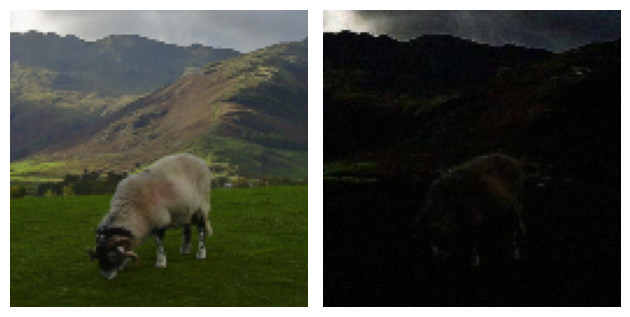

In [10]:
(natural_img, conditional_img), img_name = dataset[100]
natural_img = (natural_img + 1) / 2
conditional_img = (conditional_img + 1) / 2
plt.subplot(1, 2, 1)
plt.imshow(natural_img.permute(1, 2, 0))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(conditional_img.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()

##Forward Pass

Starting from input image $x_0$, forward pass involves injecting Gaussian noise at each timestep, $t$ into $x_{t-1}$ to produce noisy image $x_t$. Noise is fixed by us, not learning.

### Noise Schedule

Instead of linear noise schedule, we adopt consine noise schedule, which is shown to deliver better result by [Nichol et al](https://arxiv.org/abs/2102.09672).

In [11]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

##Training

Training was done in VM. Importing model and load with saved checkpoint

In [12]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00


In [13]:
from conditional_diffusion import ConditionalDiffusion

## Inference (Sampling)

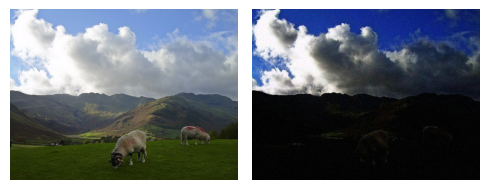

In [47]:
dataset = ConditionalDiffusionDataset("coco/coco/subset5000/coco_subset5000", "coco/coco/coco_train5000_augmented", "coco/coco/coco_ids_train_5000.json")
(ground_truth, condition), img_name = dataset[100]
plt.subplot(1, 2, 1)
plt.imshow(((ground_truth + 1) / 2).permute(1, 2, 0))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(((condition + 1) / 2).permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()

In [15]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = ConditionalDiffusion(device=device)
model.load_checkpoint("/content/drive/MyDrive/AI/diffusion_model/model_path_445.pth")

Pass in synthetic low light image on the right as condition in the model for reverse diffusion sampling from timestep T to 0. We try to get the model to generate image close to the left.

In [52]:
condition = condition.unsqueeze(0).to(device)
generated_images = model.p_sample_progressive(condition)

100%|██████████| 1000/1000 [04:44<00:00,  3.52it/s]


In [54]:
def plot(generated_images, ground_truth, steps):
  nrow = ground_truth.shape[0]
  ncol = len(steps) + 1

  for i in range(nrow):
    for j, t in enumerate(steps):
      plt.subplot(nrow, ncol, i * ncol + j + 1)
      img = (generated_images[t][i].squeeze(0) + 1) / 2 # Convert from [-1, 1] to [0, 1]
      plt.imshow(img.permute(1,2,0))
      plt.axis('off')

    plt.subplot(nrow, ncol, (i + 1) * ncol)
    img = (ground_truth[i].squeeze(0).cpu() + 1) / 2 # Convert from [-1, 1] to [0, 1]
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')

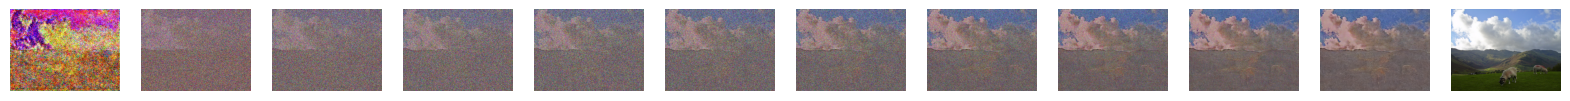

In [55]:
steps = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
plt.rcParams['figure.figsize'] = (20, 20)
plot(generated_images, ground_truth.unsqueeze(0), steps)

100%|██████████| 1000/1000 [04:44<00:00,  3.51it/s]


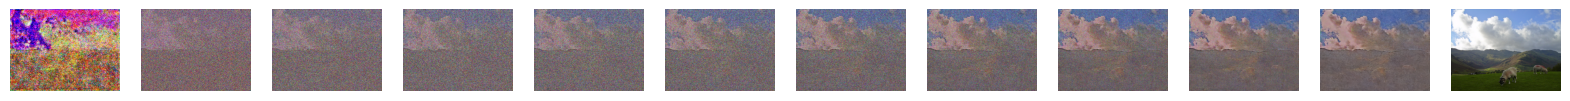

In [56]:
model.load_checkpoint("/content/drive/MyDrive/AI/diffusion_model/model_path_230.pth")
generated_images = model.p_sample_progressive(condition)
plt.rcParams['figure.figsize'] = (20, 20)
plot(generated_images, ground_truth.unsqueeze(0), steps)